In [129]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# Load airport data
airports_df = pd.read_csv("./CSVFiles/airports.csv")  # Contains Airport ID, IATA, Name, Country
routes_df = pd.read_csv("./CSVFiles/routes.csv")  # Contains Source airport, Destination airport

# Filter for US and Canada airports
US_Canada_Airports = airports_df[airports_df["Country"].isin(["United States"])]

# Map IATA codes to airport names
airport_name_map = dict(zip(US_Canada_Airports["IATA"], US_Canada_Airports["Name"]))

# Keep only flights where both airports are in US/Canada
filtered_flights = routes_df[
    (routes_df["Source airport"].isin(airport_name_map)) & 
    (routes_df["Destination airport"].isin(airport_name_map))
]

# Normalize flight direction (ensuring undirected edges)
filtered_flights["Route"] = filtered_flights.apply(lambda row: tuple(sorted([row["Source airport"], row["Destination airport"]])), axis=1)

# Count occurrences of each unique route (weight)
route_counts = filtered_flights["Route"].value_counts().reset_index()
route_counts.columns = ["Route", "Weight"]

# Split back into Source and Target
route_counts[["Source", "Target"]] = pd.DataFrame(route_counts["Route"].tolist(), index=route_counts.index)

# Create a Graph
G = nx.Graph()

# Add edges with weight
for _, row in route_counts.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Weight"])
    G.add_node(row["Source"], label = row["Source"])
# Save as GEXF (supported by Gephi)
nx.write_gexf(G, "FinalProject.gexf")

print("Filtered graph file created: FinalProject.gexf")


Filtered graph file created: FinalProject.gexf


/var/folders/m9/qv1597nx2b5fs2j38xw7mh440000gn/T/ipykernel_6939/3327180717.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_flights["Route"] = filtered_flights.apply(lambda row: tuple(sorted([row["Source airport"], row["Destination airport"]])), axis=1)


In [130]:
if not nx.is_connected(G):
    # Extract the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print("Graph is not connected. Using the largest connected component.")


Graph is not connected. Using the largest connected component.


In [131]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())
print("Average clustering coefficient:", nx.average_clustering(G))
print("Network diameter:", nx.diameter(G))
print("Average shortest path length:", nx.average_shortest_path_length(G))

Number of nodes: 541
Number of edges: 2780
Average degree: 10.277264325323475
Average clustering coefficient: 0.49437929052020224
Network diameter: 7
Average shortest path length: 3.2000479222290683


In [132]:
deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G)

top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_btw = sorted(btw_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top hubs by degree:", top_deg)
print("Top central nodes by betweenness:", top_btw)


Top hubs by degree: [('ATL', 0.2833333333333333), ('ORD', 0.27592592592592596), ('DEN', 0.27592592592592596), ('DFW', 0.2555555555555556), ('MSP', 0.21666666666666667)]
Top central nodes by betweenness: [('ANC', 0.3291603835392923), ('DEN', 0.156426745487975), ('ORD', 0.12913113732392148), ('SEA', 0.12478262126465657), ('ATL', 0.09088111207325841)]


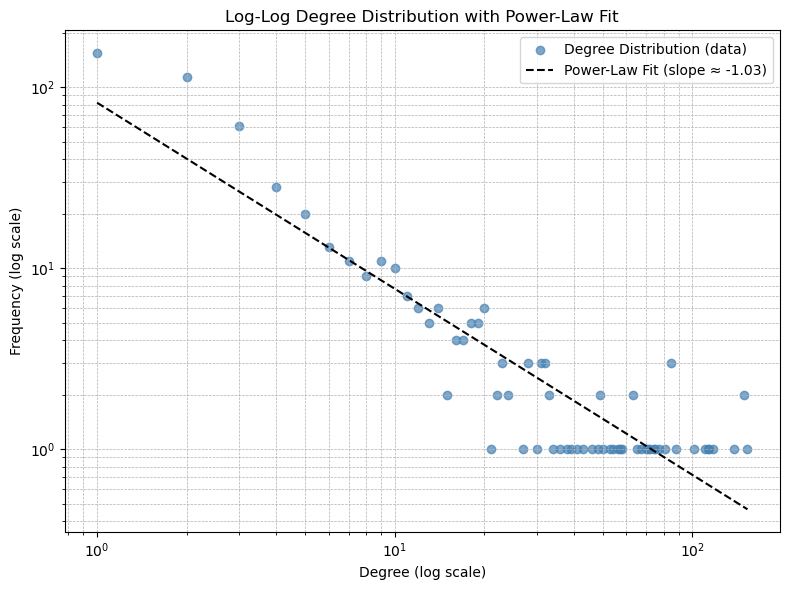

-1.03


In [133]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from scipy.stats import linregress

def plot_degree_distribution_with_powerlaw_fit(G):
    # Compute degree sequence
    degrees = [d for n, d in G.degree()]
    degree_counts = Counter(degrees)
    
    x = np.array(sorted(degree_counts.keys()))
    y = np.array([degree_counts[k] for k in x])

    # Filter out degrees <= 0 (log(0) is undefined)
    x = x[x > 0]
    y = y[:len(x)]

    # Log transform
    log_x = np.log10(x)
    log_y = np.log10(y)

    # Fit a linear model to the log-log data (this approximates power-law slope)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    y_fit = 10**(intercept + slope * log_x)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='steelblue', alpha=0.7, label='Degree Distribution (data)')
    plt.plot(x, y_fit, color='black', linestyle='--', label=f'Power-Law Fit (slope ≈ {slope:.2f})')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Log-Log Degree Distribution with Power-Law Fit')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    print(f"{slope:.2f}")
# # Load and convert the graph
# G = nx.read_graphml("Output.graphml")
# G = G.to_undirected()

# Plot the degree distribution with power-law line
plot_degree_distribution_with_powerlaw_fit(G)


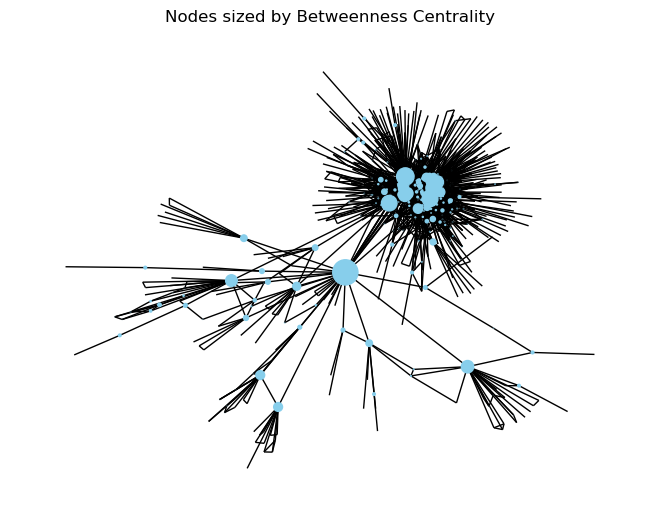

In [134]:
# Ensure centrality matches current graph
btw_cent = nx.betweenness_centrality(G)

# Layout
pos = nx.spring_layout(G, seed=42)

# Handle missing keys safely
node_sizes = [1000 * btw_cent.get(n, 0) for n in G.nodes()]

# Plot
nx.draw(G, pos, node_size=node_sizes, node_color='skyblue', with_labels=False)
plt.title("Nodes sized by Betweenness Centrality")
plt.show()


In [135]:
print("Assortativity coefficient:", nx.degree_assortativity_coefficient(G))


Assortativity coefficient: -0.34057215028189547


Power law exponent: 1.8939348650837506


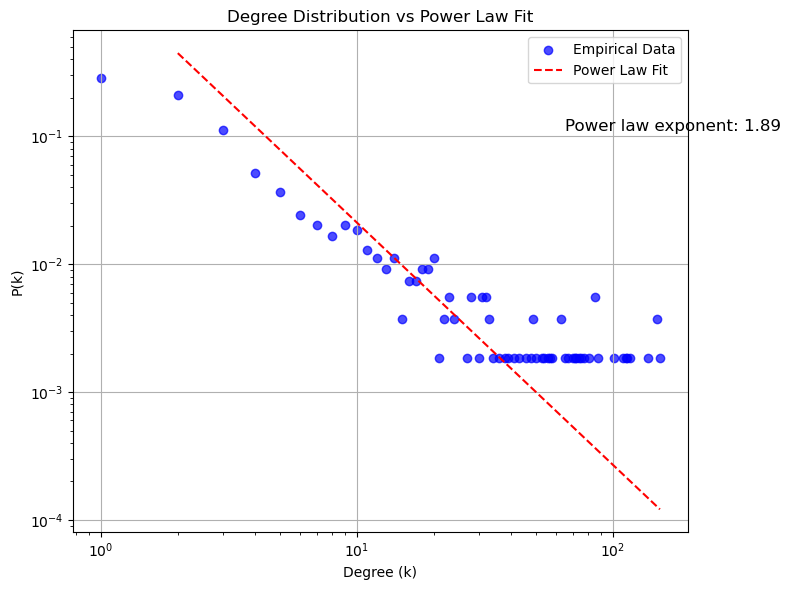

<Figure size 640x480 with 0 Axes>

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

# Compute degree sequence
degrees = [d for n, d in G.degree()]
degree_counts = np.bincount(degrees)
degree_values = np.nonzero(degree_counts)[0]
counts = degree_counts[degree_values]

# Normalize counts to probabilities
P_k = counts / sum(counts)

# Log-log scatter plot of empirical degree distribution
plt.figure(figsize=(8, 6))
plt.scatter(degree_values, P_k, color='blue', label='Empirical Data', alpha=0.7)

# Power law fit
fit = powerlaw.Fit(degrees, verbose=False)
fit.power_law.plot_pdf(color='red', linestyle='--', label='Power Law Fit')
print("Power law exponent:", fit.power_law.alpha)
# Labels and formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution vs Power Law Fit")
# display Power law exponent
plt.text(0.8, 0.8, f"Power law exponent: {fit.power_law.alpha:.2f}", fontsize=12, transform=plt.gca().transAxes)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("degree_distribution_powerlaw_fit.png", dpi=300)

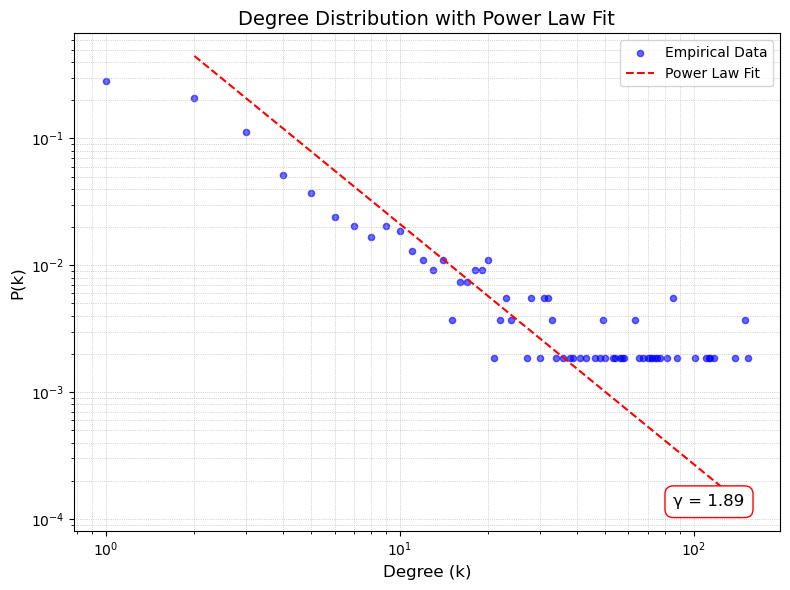

(np.float64(1.8939348650837506), np.float64(2.0))

In [157]:
# # Let's re-run the formatted visualization with a clearer output style and explanation inline
# import matplotlib.pyplot as plt
# import numpy as np
# import powerlaw

# # Ensure G is defined (use a fallback if not)
# # try:
# degree_sequence = [d for n, d in G.degree()]
# # except NameError:
# #     G = nx.barabasi_albert_graph(200, 3)
# #     degree_sequence = [d for n, d in G.degree()]

# # Calculate histogram (empirical degree distribution)
# degree_counts = np.bincount(degree_sequence)
# degree_values = np.nonzero(degree_counts)[0]
# counts = degree_counts[degree_values]
# P_k = counts / sum(counts)

# # Fit the degree distribution to a power law
# fit = powerlaw.Fit(degree_sequence, verbose=False)
# alpha = fit.power_law.alpha
# xmin = fit.power_law.xmin

# # Plot
# plt.figure(figsize=(8, 6))
# plt.scatter(degree_values, P_k, color='blue', label='Empirical Data', alpha=0.6, s=20)
# fit.power_law.plot_pdf(color='red', linestyle='--', label=f'Power Law Fit\n(α={alpha:.2f}, xmin={xmin})')

# # Format log-log plot
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Degree (k)", fontsize=12)
# plt.ylabel("P(k)", fontsize=12)
# plt.title("Degree Distribution with Power Law Fit", fontsize=14)
# plt.legend()
# plt.grid(True, which="both", linestyle=":", linewidth=0.5)
# plt.tight_layout()
# plt.savefig("degree_distribution_powerlaw_fit.png", dpi=300)
# plt.show()

# # Provide explanation
# alpha, xmin
# Re-import required packages since kernel has reset
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

# Generate the graph if not already defined
# G = nx.barabasi_albert_graph(200, 3)

# Calculate degree sequence
degree_sequence = [d for n, d in G.degree()]
degree_counts = np.bincount(degree_sequence)
degree_values = np.nonzero(degree_counts)[0]
counts = degree_counts[degree_values]
P_k = counts / sum(counts)

# Fit the power law
fit = powerlaw.Fit(degree_sequence, verbose=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(degree_values, P_k, color='blue', label='Empirical Data', alpha=0.6, s=20)
fit.power_law.plot_pdf(color='red', linestyle='--', label='Power Law Fit')

# Add gamma value in a red-bordered box
plt.text(0.95, 0.05, f"γ = {alpha:.2f}", fontsize=12, color='black',
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'),
         transform=plt.gca().transAxes, ha='right')

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)", fontsize=12)
plt.ylabel("P(k)", fontsize=12)
plt.title("Degree Distribution with Power Law Fit", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.savefig("degree_distribution_powerlaw_fit.png", dpi=300)
plt.show()

(alpha, xmin)



In [138]:
if not nx.is_connected(G):
    # Extract the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print("Graph is not connected. Using the largest connected component.")

n, m = G.number_of_nodes(), G.number_of_edges()

# Random graph
ER = nx.gnm_random_graph(n, m)
# Scale-free
BA = nx.barabasi_albert_graph(n, m // n)
# Configuration model
deg_seq = [d for n, d in G.degree()]
# After creating the configuration model
CFG = nx.configuration_model(deg_seq)

# # Convert to simple graph (removes parallel edges and self-loops)
CFG = nx.Graph(CFG)  # Remove multiedges
CFG.remove_edges_from(nx.selfloop_edges(CFG))  # Remove self-loops


def compare_networks(name, H):
    print(f"--- {name} ---")
    print("Avg Clustering:", nx.average_clustering(H))
    try:
        if not nx.is_connected(H):
            H = H.subgraph(max(nx.connected_components(H), key=len)).copy()
            print(f"Note: {name} was disconnected — used its largest connected component.")
        print("Avg Path Length:", nx.average_shortest_path_length(H))
    except Exception as e:
        print("Avg Path Length: Error -", e)
    
    print("Degree Assortativity:", nx.degree_assortativity_coefficient(H))


compare_networks("Original", G)
compare_networks("Random", ER)
compare_networks("Scale-Free", BA)
compare_networks("Configuration", CFG)


--- Original ---
Avg Clustering: 0.49437929052020224
Avg Path Length: 3.2000479222290683
Degree Assortativity: -0.34057215028189547
--- Random ---
Avg Clustering: 0.020295659517831507
Avg Path Length: 2.94323269665229
Degree Assortativity: 0.030290628431785132
--- Scale-Free ---
Avg Clustering: 0.06028267754551761
Avg Path Length: 2.7971109741904567
Degree Assortativity: -0.05982607707822157
--- Configuration ---
Avg Clustering: 0.19359194955405246
Note: Configuration was disconnected — used its largest connected component.
Avg Path Length: 3.012244040743463
Degree Assortativity: -0.12235267395189224


Detected communities: 50


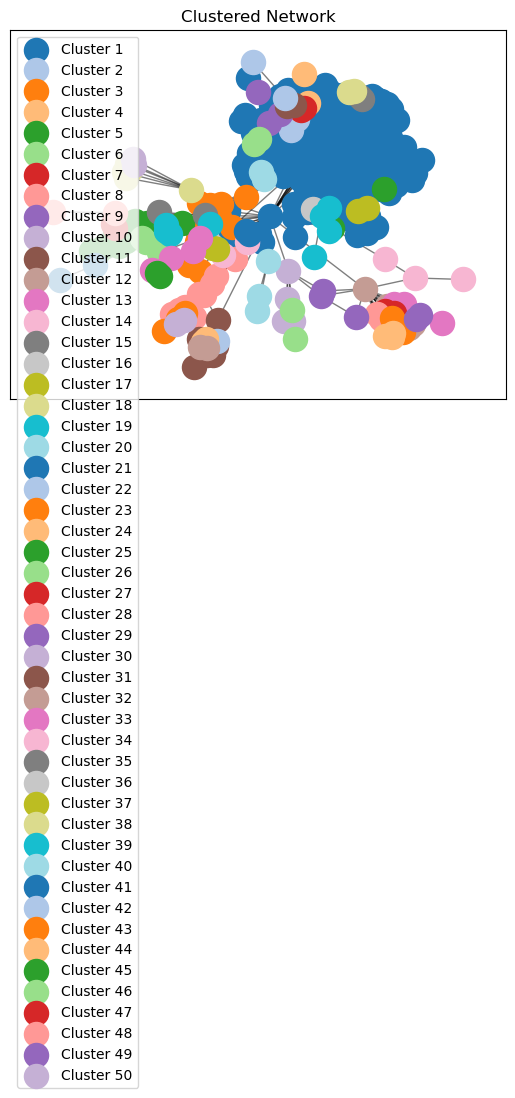

In [139]:
from networkx.algorithms import community

# Label propagation
communities = list(community.label_propagation_communities(G))
print("Detected communities:", len(communities))

# Visualize
import itertools
colors = itertools.cycle(plt.cm.tab20.colors)
for i, com in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=list(com), node_color=[next(colors)], label=f"Cluster {i+1}")
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Clustered Network")
plt.legend()
plt.show()


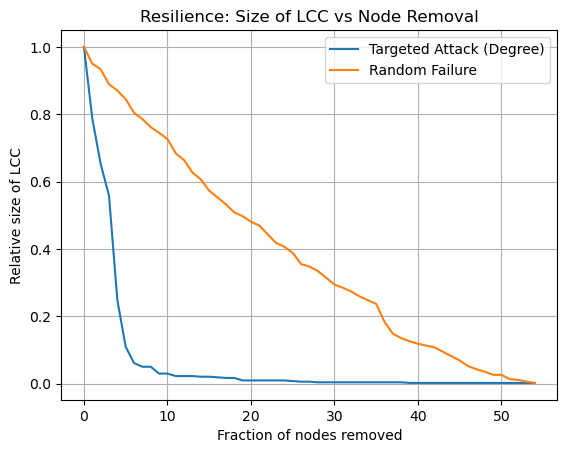

In [140]:
import copy

def resilience_attack_vs_failure(G, metric='degree'):
    def remove_nodes_and_measure(G, strategy):
        size_lcc = []
        G_temp = G.copy()
        nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
        for i in range(0, len(nodes), max(1, len(nodes)//50)):
            G_temp.remove_nodes_from(nodes[:i])
            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                size_lcc.append(len(lcc) / G.number_of_nodes())
        return size_lcc

    attack = remove_nodes_and_measure(G, lambda x: G.degree[x])
    rand = remove_nodes_and_measure(G, lambda x: np.random.rand())
    
    plt.plot(attack, label="Targeted Attack (Degree)")
    plt.plot(rand, label="Random Failure")
    plt.title("Resilience: Size of LCC vs Node Removal")
    plt.xlabel("Fraction of nodes removed")
    plt.ylabel("Relative size of LCC")
    plt.legend()
    plt.grid(True)
    plt.show()

resilience_attack_vs_failure(G)


In [141]:
import random

def si_spread_simulation(G, beta=0.05, initial_infected=None, max_steps=50):
    infected = set()
    if initial_infected is None:
        initial_infected = random.choice(list(G.nodes()))
    infected.add(initial_infected)
    
    spread_history = [len(infected) / G.number_of_nodes()]
    
    for _ in range(max_steps):
        new_infected = set(infected)
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < beta:
                    new_infected.add(neighbor)
        if new_infected == infected:
            break  # No more spread
        infected = new_infected
        spread_history.append(len(infected) / G.number_of_nodes())
    
    return spread_history


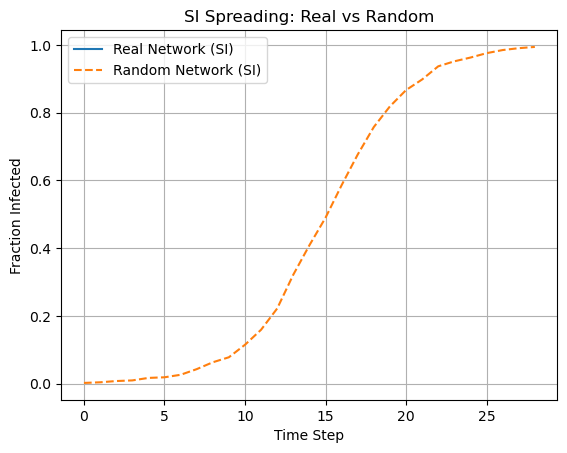

In [142]:
real_si = si_spread_simulation(G)
random_si = si_spread_simulation(ER)

plt.plot(real_si, label='Real Network (SI)')
plt.plot(random_si, label='Random Network (SI)', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Fraction Infected")
plt.title("SI Spreading: Real vs Random")
plt.legend()
plt.grid(True)
plt.show()


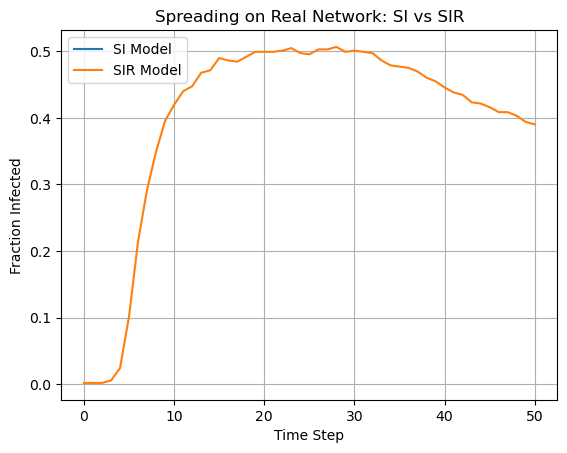

In [143]:
def sir_spread_simulation(G, beta=0.05, gamma=0.02, initial_infected=None, max_steps=50):
    susceptible = set(G.nodes())
    infected = set()
    recovered = set()
    
    if initial_infected is None:
        initial_infected = random.choice(list(G.nodes()))
    infected.add(initial_infected)
    susceptible.remove(initial_infected)
    
    infected_frac = [len(infected) / G.number_of_nodes()]
    
    for _ in range(max_steps):
        new_infected = set()
        new_recovered = set()
        
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
            if random.random() < gamma:
                new_recovered.add(node)
        
        infected |= new_infected
        infected -= new_recovered
        recovered |= new_recovered
        susceptible -= new_infected
        
        infected_frac.append(len(infected) / G.number_of_nodes())
        
        if not infected:
            break
    
    return infected_frac

si_curve = si_spread_simulation(G)
sir_curve = sir_spread_simulation(G)

plt.plot(si_curve, label='SI Model')
plt.plot(sir_curve, label='SIR Model')
plt.xlabel("Time Step")
plt.ylabel("Fraction Infected")
plt.title("Spreading on Real Network: SI vs SIR")
plt.legend()
plt.grid(True)
plt.show()



In [144]:
def immunize_graph(G, strategy='random', frac=0.1):
    G_copy = G.copy()
    n_remove = int(frac * G.number_of_nodes())
    
    if strategy == 'random':
        to_remove = random.sample(list(G.nodes()), n_remove)
    elif strategy == 'high_degree':
        to_remove = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:n_remove]
        to_remove = [n for n, d in to_remove]
    
    G_copy.remove_nodes_from(to_remove)
    return G_copy


In [145]:
def immunize_graph(G, strategy='random', frac=0.1):
    G_copy = G.copy()
    n_remove = int(frac * G.number_of_nodes())
    
    if strategy == 'random':
        to_remove = random.sample(list(G.nodes()), n_remove)
    elif strategy == 'high_degree':
        to_remove = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:n_remove]
        to_remove = [n for n, d in to_remove]
    
    G_copy.remove_nodes_from(to_remove)
    return G_copy


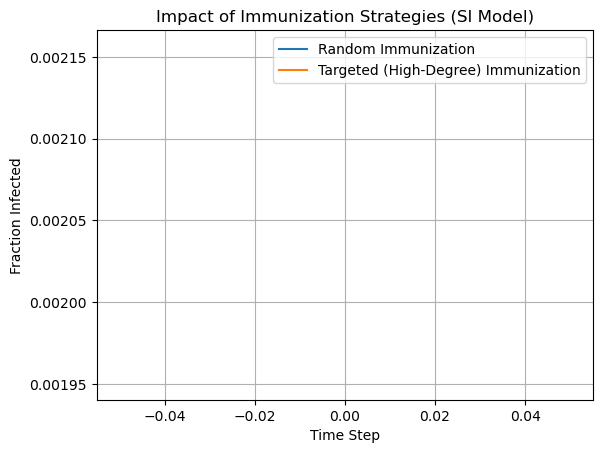

In [146]:

G_random_immunized = immunize_graph(G, strategy='random', frac=0.1)
G_targeted_immunized = immunize_graph(G, strategy='high_degree', frac=0.1)

spread_random = si_spread_simulation(G_random_immunized)
spread_targeted = si_spread_simulation(G_targeted_immunized)

plt.plot(spread_random, label="Random Immunization")
plt.plot(spread_targeted, label="Targeted (High-Degree) Immunization")
plt.xlabel("Time Step")
plt.ylabel("Fraction Infected")
plt.title("Impact of Immunization Strategies (SI Model)")
plt.legend()
plt.grid(True)
plt.show()


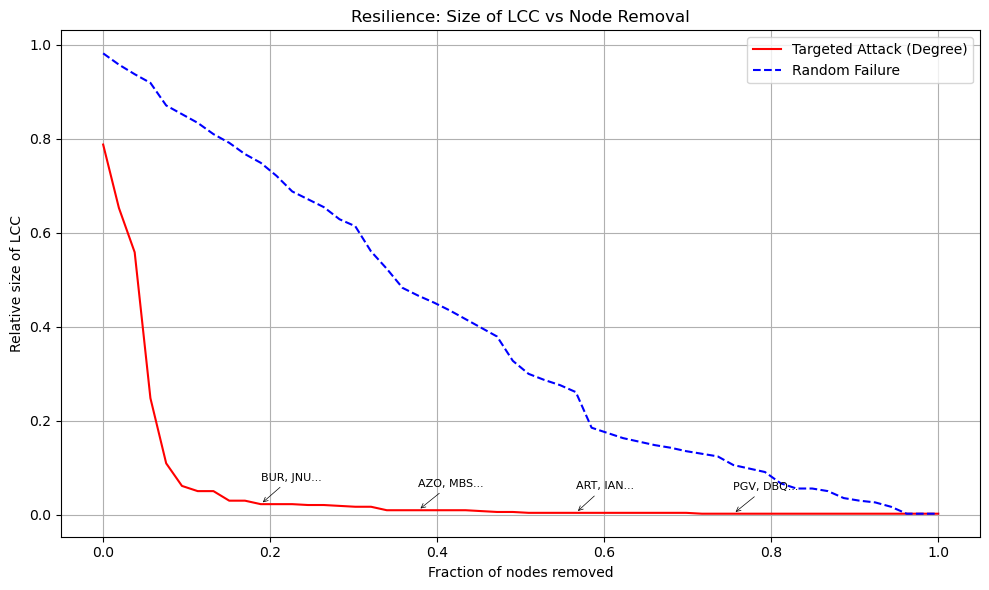

In [147]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def resilience_attack_vs_failure(G, metric='degree'):
    def remove_nodes_and_measure(G, strategy, label):
        size_lcc = []
        dropped_nodes = []
        G_temp = G.copy()
        nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
        step_size = max(1, len(nodes) // 50)
        
        for i in range(0, len(nodes), step_size):
            current_dropped = nodes[i : i + step_size]
            dropped_nodes.append(current_dropped)
            G_temp.remove_nodes_from(current_dropped)
            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                size_lcc.append(len(lcc) / G.number_of_nodes())
        
        return size_lcc, dropped_nodes

    # Run both simulations
    attack_lcc, attack_drops = remove_nodes_and_measure(G, lambda x: G.degree[x], "attack")
    random_lcc, random_drops = remove_nodes_and_measure(G, lambda x: np.random.rand(), "random")

    # Plot
    steps = np.linspace(0, 1, len(attack_lcc))
    plt.figure(figsize=(10, 6))
    plt.plot(steps, attack_lcc, label="Targeted Attack (Degree)", color='red')
    plt.plot(steps, random_lcc, label="Random Failure", color='blue', linestyle='--')
    
    # Annotate dropped nodes at some key points (optional)
    for i in [10, 20, 30, 40]:  # Sample 4 steps to annotate
        if i < len(attack_drops):
            label = ", ".join(attack_drops[i][:2]) + "..."  # Only show 2 node names
            plt.annotate(label, xy=(steps[i], attack_lcc[i]),
                         xytext=(steps[i], attack_lcc[i] + 0.05),
                         arrowprops=dict(arrowstyle="->", lw=0.5),
                         fontsize=8)

    plt.title("Resilience: Size of LCC vs Node Removal")
    plt.xlabel("Fraction of nodes removed")
    plt.ylabel("Relative size of LCC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

resilience_attack_vs_failure(G)


Targeted Attack (Degree) Random Failure
                     ATL            KTN
                     ORD            MCI
                     DEN            PUB
                     DFW            BQK
                     MSP            CIK
                     DTW            PHF
                     LAS            JAX
                     CLT            EEK
                     IAH            GSP
                     PHL            UNK
                     LAX            ADQ
                     DCA            ROC
                     SLC            EGX
                     IAD            ACV
                     PHX            CDC
                     SEA            APF
                     MCO            IMT
                     EWR            LNK
                     SFO            AET
                     BOS            TBN
                     MDW            LAR
                     LGA            CGI
                     TPA            RNO
                     BWI            TVF


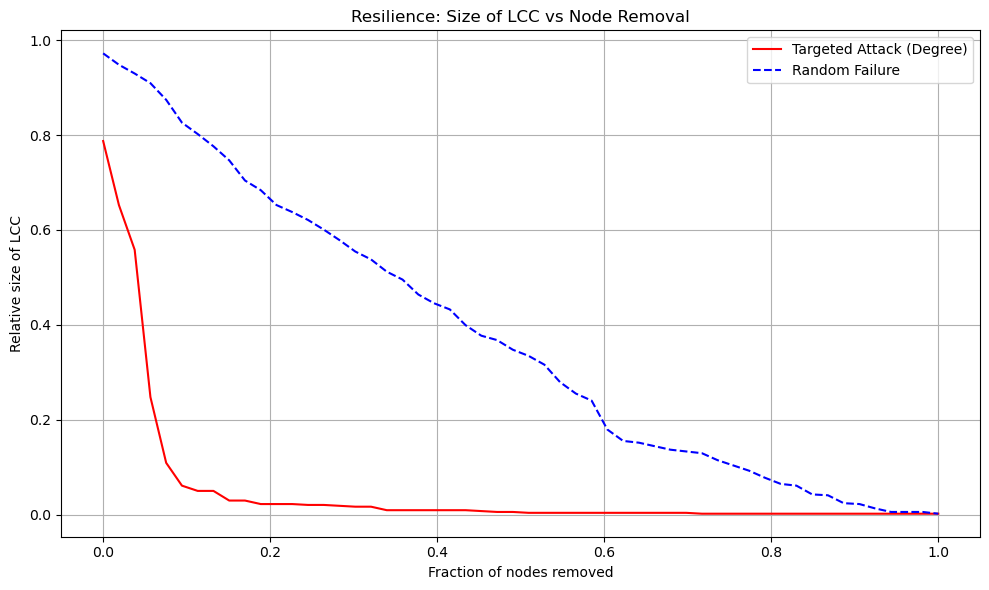

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

def resilience_attack_vs_failure_with_log(G):
    def remove_nodes_and_measure(G, strategy):
        size_lcc = []
        dropped_nodes = []
        G_temp = G.copy()
        nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
        step_size = max(1, len(nodes) // 50)
        
        for i in range(0, len(nodes), step_size):
            current_dropped = nodes[i : i + step_size]
            dropped_nodes.append(current_dropped)
            G_temp.remove_nodes_from(current_dropped)
            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                size_lcc.append(len(lcc) / G.number_of_nodes())
        
        return size_lcc, dropped_nodes

    # Run simulations
    attack_lcc, attack_drops = remove_nodes_and_measure(G, lambda x: G.degree[x])
    random_lcc, random_drops = remove_nodes_and_measure(G, lambda x: np.random.rand())

    # Flatten and align lengths for DataFrame
    all_attack_dropped = [node for group in attack_drops for node in group]
    all_random_dropped = [node for group in random_drops for node in group]
    max_len = max(len(all_attack_dropped), len(all_random_dropped))
    all_attack_dropped += [''] * (max_len - len(all_attack_dropped))
    all_random_dropped += [''] * (max_len - len(all_random_dropped))

    df = pd.DataFrame({
        'Targeted Attack (Degree)': all_attack_dropped,
        'Random Failure': all_random_dropped
    })

    # Show the table
    print(df.to_string(index=False))

    # Plot
    steps = np.linspace(0, 1, len(attack_lcc))
    plt.figure(figsize=(10, 6))
    plt.plot(steps, attack_lcc, label="Targeted Attack (Degree)", color='red')
    plt.plot(steps, random_lcc, label="Random Failure", color='blue', linestyle='--')
    plt.title("Resilience: Size of LCC vs Node Removal")
    plt.xlabel("Fraction of nodes removed")
    plt.ylabel("Relative size of LCC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Make sure G is defined before calling
# Example:
# G = nx.read_graphml("Output.graphml")
resilience_attack_vs_failure_with_log(G)


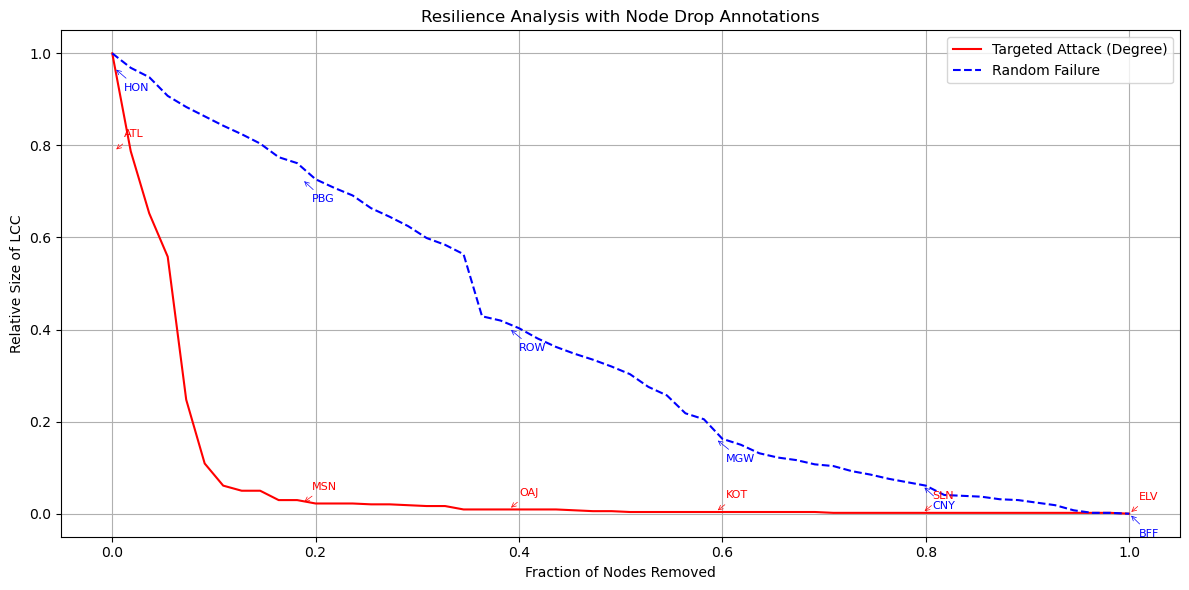

,Attack_Step,Attack_Node,Attack_LCC_Size,Random_Step,Random_Node,Random_LCC_Size
0,0,ATL,0.787431,0,HON,0.968577
1,0,ORD,0.787431,0,PAH,0.968577
2,0,DEN,0.787431,0,PKB,0.968577
3,0,DFW,0.787431,0,ITO,0.968577
4,0,MSP,0.787431,0,LNY,0.968577
...,...,...,...,...,...,...
536,53,KPV,0.001848,53,AKK,0.001848
537,53,IGG,0.001848,53,JAX,0.001848
538,53,PIP,0.001848,53,BGR,0.001848
539,53,AGN,0.001848,53,MHK,0.001848


In [149]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

def resilience_attack_vs_failure_with_timestamp(G):
    def remove_nodes_and_measure(G, strategy):
        size_lcc = [1.0]  # Start with full size
        dropped_log = []
        G_temp = G.copy()
        nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
        step_size = max(1, len(nodes) // 50)
        
        for step, i in enumerate(range(0, len(nodes), step_size)):
            current_dropped = nodes[i : i + step_size]
            G_temp.remove_nodes_from(current_dropped)
            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                lcc_size = len(lcc) / G.number_of_nodes()
                size_lcc.append(lcc_size)
            else:
                lcc_size = 0
                size_lcc.append(0)
            for node in current_dropped:
                dropped_log.append({
                    "Step": step,
                    "Node": node,
                    "Remaining_LCC_Size": lcc_size,
                    "Fraction_Removed": (i + 1) / G.number_of_nodes()
                })
        
        return size_lcc, dropped_log

    # Run both simulations
    attack_lcc, attack_log = remove_nodes_and_measure(G, lambda x: G.degree[x])
    random_lcc, random_log = remove_nodes_and_measure(G, lambda x: np.random.rand())

    # Create DataFrames
    df_attack = pd.DataFrame(attack_log)
    df_random = pd.DataFrame(random_log)

    # Merge for side-by-side comparison
    max_len = max(len(df_attack), len(df_random))
    df_attack = df_attack.reindex(range(max_len)).reset_index(drop=True)
    df_random = df_random.reindex(range(max_len)).reset_index(drop=True)
    df_combined = pd.DataFrame({
        'Attack_Step': df_attack['Step'],
        'Attack_Node': df_attack['Node'],
        'Attack_LCC_Size': df_attack['Remaining_LCC_Size'],
        'Random_Step': df_random['Step'],
        'Random_Node': df_random['Node'],
        'Random_LCC_Size': df_random['Remaining_LCC_Size']
    })

    # Visualize with annotations
    steps = np.linspace(0, 1, len(attack_lcc))
    plt.figure(figsize=(12, 6))
    plt.plot(steps, attack_lcc, label="Targeted Attack (Degree)", color='red')
    plt.plot(steps , random_lcc, label="Random Failure", color='blue', linestyle='--')

    # Annotate first few drops for each
    for idx in range(0, len(attack_log), max(1, len(attack_log)//5)):
        point = attack_log[idx]
        plt.annotate(point["Node"], xy=(point["Fraction_Removed"], point["Remaining_LCC_Size"]),
                     xytext=(point["Fraction_Removed"] + 0.01, point["Remaining_LCC_Size"] + 0.03),
                     fontsize=8, color='red', arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    for idx in range(0, len(random_log), max(1, len(random_log)//5)):
        point = random_log[idx]
        plt.annotate(point["Node"], xy=(point["Fraction_Removed"], point["Remaining_LCC_Size"]),
                     xytext=(point["Fraction_Removed"] + 0.01, point["Remaining_LCC_Size"] - 0.05),
                     fontsize=8, color='blue', arrowprops=dict(arrowstyle='->', color='blue', lw=0.5))

    plt.title("Resilience Analysis with Node Drop Annotations")
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Relative Size of LCC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_combined

# Run if G is defined
# Example: G = nx.read_graphml("Output.graphml")
resilience_attack_vs_failure_with_timestamp(G)


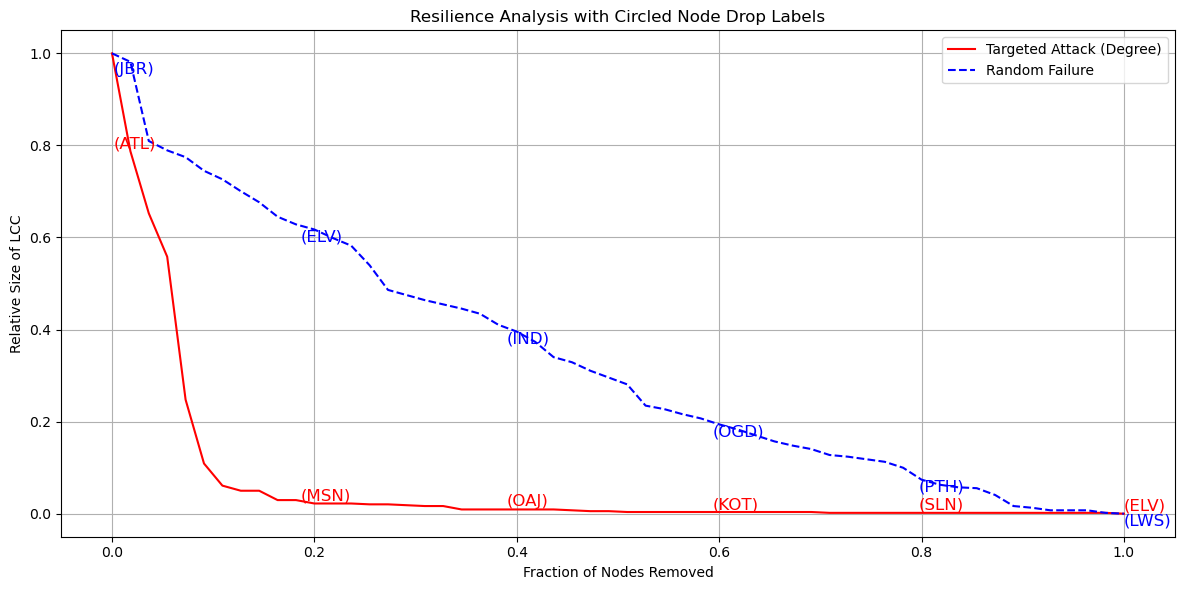

In [150]:
# Redefine the function to circle the node names instead of using arrows

def resilience_attack_vs_failure_with_circles(G):
    def remove_nodes_and_measure(G, strategy):
        size_lcc = [1.0]  # Start with full size
        dropped_log = []
        G_temp = G.copy()
        nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
        step_size = max(1, len(nodes) // 50)

        for step, i in enumerate(range(0, len(nodes), step_size)):
            current_dropped = nodes[i : i + step_size]
            G_temp.remove_nodes_from(current_dropped)
            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                lcc_size = len(lcc) / G.number_of_nodes()
                size_lcc.append(lcc_size)
            else:
                lcc_size = 0
                size_lcc.append(0)
            for node in current_dropped:
                dropped_log.append({
                    "Step": step,
                    "Node": node,
                    "Remaining_LCC_Size": lcc_size,
                    "Fraction_Removed": (i + 1) / G.number_of_nodes()
                })

        return size_lcc, dropped_log

    # Run both simulations
    attack_lcc, attack_log = remove_nodes_and_measure(G, lambda x: G.degree[x])
    random_lcc, random_log = remove_nodes_and_measure(G, lambda x: np.random.rand())

    # Create DataFrames
    df_attack = pd.DataFrame(attack_log)
    df_random = pd.DataFrame(random_log)

    # Merge for side-by-side comparison
    max_len = max(len(df_attack), len(df_random))
    df_attack = df_attack.reindex(range(max_len)).reset_index(drop=True)
    df_random = df_random.reindex(range(max_len)).reset_index(drop=True)
    df_combined = pd.DataFrame({
        'Attack_Step': df_attack['Step'],
        'Attack_Node': df_attack['Node'],
        'Attack_LCC_Size': df_attack['Remaining_LCC_Size'],
        'Random_Step': df_random['Step'],
        'Random_Node': df_random['Node'],
        'Random_LCC_Size': df_random['Remaining_LCC_Size']
    })

    # Visualize with node labels circled
    steps = np.linspace(0, 1, len(attack_lcc))
    plt.figure(figsize=(12, 6))
    plt.plot(steps, attack_lcc, label="Targeted Attack (Degree)", color='red')
    plt.plot(steps , random_lcc, label="Random Failure", color='blue', linestyle='--')

    # Annotate first few drops with circled labels
    for idx in range(0, len(attack_log), max(1, len(attack_log)//5)):
        point = attack_log[idx]
        plt.text(point["Fraction_Removed"], point["Remaining_LCC_Size"], f'({point["Node"]})',
                 fontsize=12, color='red', ha='left', va='bottom')

    for idx in range(0, len(random_log), max(1, len(random_log)//5)):
        point = random_log[idx]
        plt.text(point["Fraction_Removed"], point["Remaining_LCC_Size"], f'({point["Node"]})',
                 fontsize=12, color='blue', ha='left', va='top')

    plt.title("Resilience Analysis with Circled Node Drop Labels")
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Relative Size of LCC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_combined

# Run the modified function on the same connected graph
df_result_with_circles = resilience_attack_vs_failure_with_circles(G)


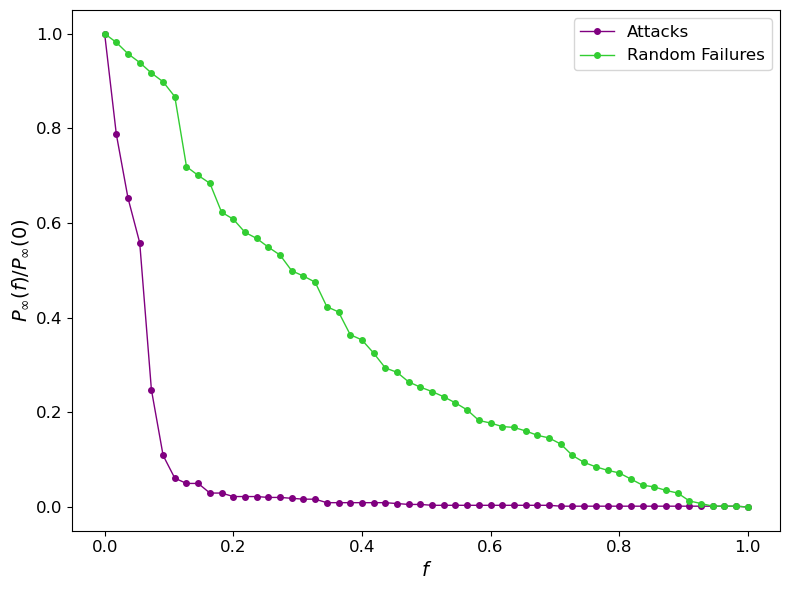

In [151]:

# Define the function for a clean comparison plot
def plot_resilience_clean(G):
    def compute_lcc_over_removal(G, strategy):
        sizes = [1.0]
        G_temp = G.copy()
        nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
        step_size = max(1, len(nodes) // 50)
        for i in range(0, len(nodes), step_size):
            G_temp.remove_nodes_from(nodes[i:i + step_size])
            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                sizes.append(len(lcc) / G.number_of_nodes())
            else:
                sizes.append(0)
        return sizes

    attack_lcc = compute_lcc_over_removal(G, lambda x: G.degree[x])
    random_lcc = compute_lcc_over_removal(G, lambda x: np.random.rand())

    # Normalize steps for plotting
    x = np.linspace(0, 1, len(attack_lcc))

    # Plot in the style of the image
    plt.figure(figsize=(8, 6))
    plt.plot(x, attack_lcc, 'o-', color='purple', label='Attacks', markersize=4, linewidth=1)
    plt.plot(x, random_lcc, 'o-', color='limegreen', label='Random Failures', markersize=4, linewidth=1)

    # Style
    plt.xlabel(r'$f$', fontsize=14)
    plt.ylabel(r'$P_\infty(f) / P_\infty(0)$', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.legend(loc='best', fontsize=12)
    plt.title("")
    plt.tight_layout()
    plt.show()

plot_resilience_clean(G)


In [152]:
# Purple circles show the drop in LCC size from targeted attacks

# Green circles represent the impact of random failures

# Axes are labeled with LaTeX-style math:

# 𝑓
# f: fraction of nodes removed

# 𝑃
# ∞
# (
# 𝑓
# )
# /
# 𝑃
# ∞
# (
# 0
# )
# P 
# ∞
# ​
#  (f)/P 
# ∞
# ​
#  (0): relative size of the largest connected component

In [153]:
# Modify to log which nodes are removed at each step and include them in the resilience table

def compute_lcc_with_node_log(G, strategy, label):
    sizes = [1.0]
    fractions = [0.0]
    dropped_nodes = ["None"]
    G_temp = G.copy()
    nodes = sorted(G_temp.nodes(), key=strategy, reverse=True)
    step_size = max(1, len(nodes) // 50)

    for i in range(0, len(nodes), step_size):
        current_nodes = nodes[i:i + step_size]
        G_temp.remove_nodes_from(current_nodes)

        if len(G_temp) > 0:
            lcc = max(nx.connected_components(G_temp), key=len)
            lcc_size = len(lcc) / G.number_of_nodes()
        else:
            lcc_size = 0

        sizes.append(lcc_size)
        fractions.append((i + step_size) / G.number_of_nodes())
        dropped_nodes.append(", ".join(map(str, current_nodes)))

    return pd.DataFrame({
        'Fraction_Removed': fractions,
        f'{label}_LCC_Size': sizes,
        f'{label}_Dropped_Nodes': dropped_nodes
    })

# Compute for both attack and random failure
df_attack_log = compute_lcc_with_node_log(G, lambda x: G.degree[x], 'Attack')
df_random_log = compute_lcc_with_node_log(G, lambda x: np.random.rand(), 'Random')

# Merge into one DataFrame
df_resilience_log = pd.merge(df_attack_log, df_random_log, on='Fraction_Removed')

# Display the first few rows for inspection
df_resilience_log.head(20)


,Fraction_Removed,Attack_LCC_Size,Attack_Dropped_Nodes,Random_LCC_Size,Random_Dropped_Nodes
0,0.000000,1.000000,None,1.000000,None
1,0.018484,0.787431,"ATL, ORD, DEN, DFW, MSP, DTW, LAS, CLT, IAH, PHL",0.970425,"LGA, WMO, ABI, BTM, ELV, KTS, LCH, ADQ, JAC, SFO"
2,0.036969,0.652495,"LAX, DCA, SLC, IAD, PHX, SEA, MCO, EWR, SFO, BOS",0.951941,"GUC, CNM, ISN, FWA, LAM, MUE, SOW, MKG, LAN, HOT"
3,0.055453,0.558226,"MDW, LGA, TPA, BWI, FLL, JFK, STL, PDX, CLE, SAN",0.903882,"EAT, ROA, MYU, CRW, DRG, ELP, VPS, IAD, EMK, DFW"
4,0.073937,0.247689,"MIA, HOU, SFB, BNA, CVG, MCI, AUS, MSY, RDU, ANC",0.889094,"SAV, MOD, MCK, DIK, RDD, LMT, SNP, PIT, FAY, OGS"
5,0.092421,0.109057,"PIT, OAK, IND, MEM, AZA, CMH, RSW, PIE, SAT, HNL",0.861368,"AIN, ANI, SNA, COU, AKP, ATW, SKK, PSM, GRK, ADK"
6,0.110906,0.060998,"MKE, SMF, SJC, JAX, DAL, BDL, SDF, ABQ, OKC, BET",0.842884,"BQK, TYR, SCM, KLW, NLG, KKH, BGM, HHH, SMK, PSG"
7,0.129390,0.049908,"MYR, OGG, CHS, GSP, OMA, BUF, GRR, PBI, ORF, BHM",0.824399,"IMT, HNL, COD, RNO, LUK, CLD, GSO, BLV, NUL, ART"
8,0.147874,0.049908,"ALB, PVD, RIC, TUL, SNA, FAI, PGD, TYS, ROC, LIT",0.780037,"FSD, BFF, PIE, CYF, PDX, WRG, LSE, AMA, GSP, ATL"
9,0.166359,0.029575,"DSM, DAY, TUS, HPN, BOI, SYR, OME, RNO, GSO, XNA",0.731978,"PIZ, VLD, HGR, HNS, IDA, LEB, PTU, ARC, DEN, TRI"


In [154]:
import networkx as nx
import powerlaw

# G = nx.barabasi_albert_graph(200, 3)
degrees = [d for n, d in G.degree()]
fit = powerlaw.Fit(degrees, verbose=False)

gamma = fit.power_law.alpha
xmin = fit.power_law.xmin

print("Power law exponent (γ):", gamma)
print("Fit starts at xmin:", xmin)


Power law exponent (γ): 1.8939348650837506
Fit starts at xmin: 2.0
